# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(train['features'])

# TODO: Number of testing examples.
n_test = len(test['features'])

# TODO: What's the shape of an traffic sign image?
image_shape = train['features'][0].shape
num_channels = 3  # grey scale

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(train['labels']) - min(train['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

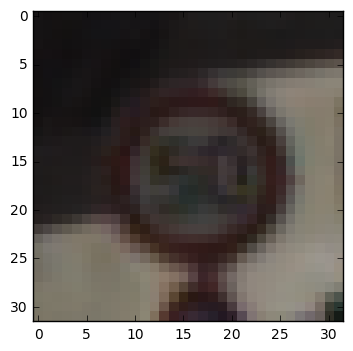

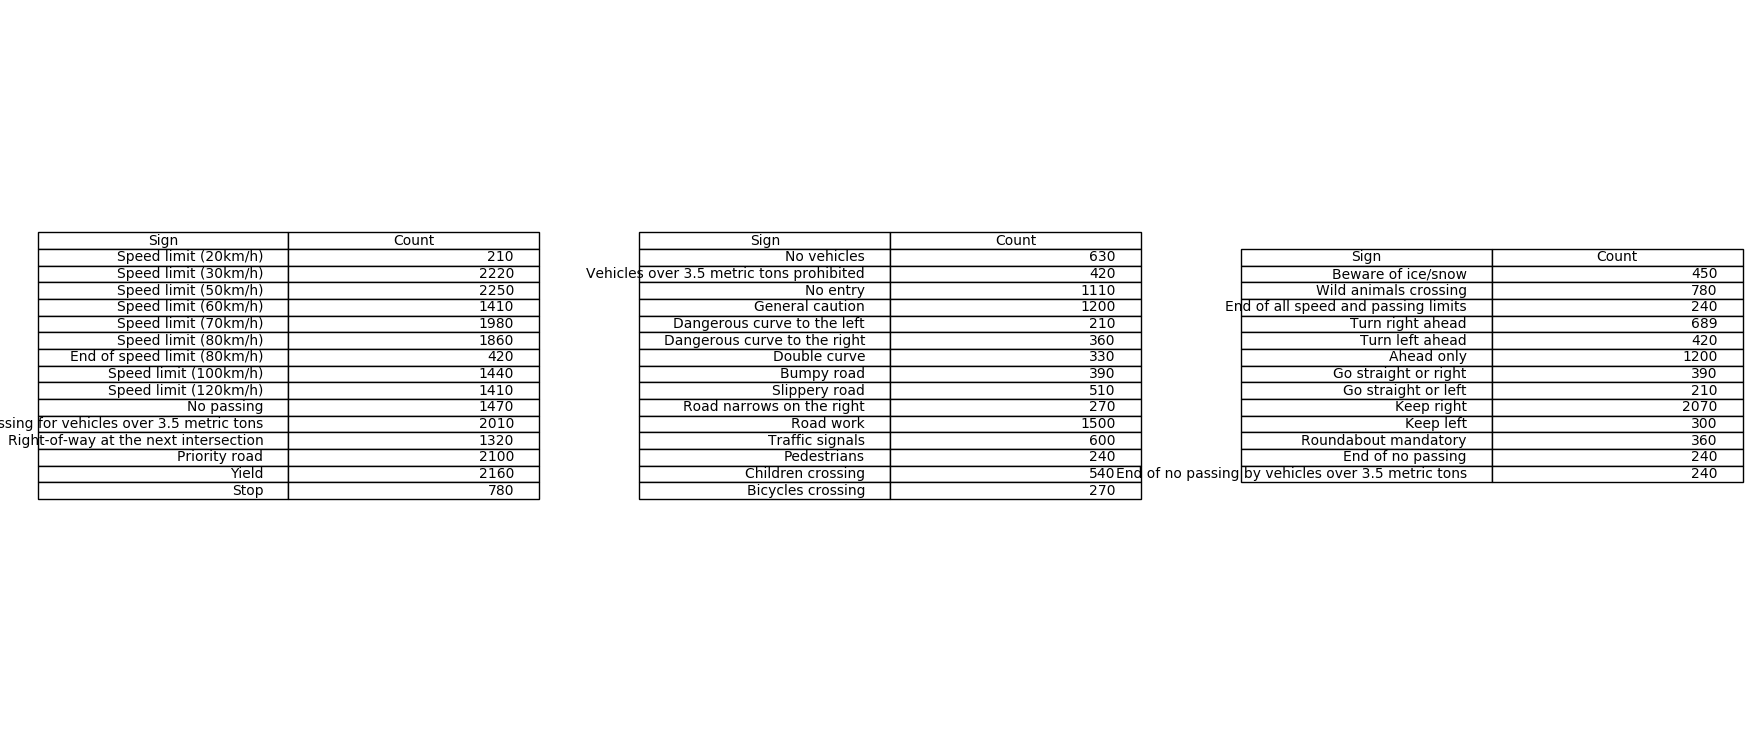

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
# Visualizations will be shown in the notebook.

plt.imshow(train['features'][np.random.randint(0, len(train['features']))], interpolation='nearest', cmap=cm.brg)

from collections import Counter
with open('signnames.csv', 'r') as f:
    temp = f.readlines()
    sign_map = {int(i.split(",")[0]): i.split(",")[1].strip() for i in temp if not i.startswith('ClassId')}
a = [[], [], []]; b = [[], []]
for i in Counter(train['labels']).items():
    if len(a[0]) < 15:
        a[0].append([sign_map[i[0]], i[1]])
    elif len(a[1]) < 15:
        a[1].append([sign_map[i[0]], i[1]])
    else:
        a[2].append([sign_map[i[0]], i[1]])
    b[0].append(i[0]); b[1].append(i[1])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 9))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].table(cellText=a[0], colLabels=['Sign', 'Count'], loc='center', fontsize=13).auto_set_font_size(False)
ax[1].table(cellText=a[1], colLabels=['Sign', 'Count'], loc='center', fontsize=13).auto_set_font_size(False)
ax[2].table(cellText=a[2], colLabels=['Sign', 'Count'], loc='center', fontsize=13).auto_set_font_size(False)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
# create validation set
X_valid, X_test = np.split(X_test, 2)
y_valid, y_test = np.split(y_test, 2)
# randomize training/test data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
# reformat to grayscale
# temp = np.zeros_like(X_train, dtype=np.float32)
# temp = temp.reshape((-1, image_shape[0], image_shape[0], num_channels))
# for i, j in enumerate(X_train):
#     for k, l in enumerate(j):
#         temp[i][k] = np.mean(l)
# temp = temp[:i + 1, :, :]
# X_train = temp
# #
# temp = np.zeros_like(X_valid, dtype=np.float32)
# temp = temp.reshape((-1, image_shape[0], image_shape[0], num_channels))
# for i, j in enumerate(X_valid):
#     for k, l in enumerate(j):
#         temp[i][k] = np.mean(l)
# temp = temp[:i + 1, :, :]
# X_valid = temp
#
# temp = np.zeros_like(X_test, dtype=np.float32)
# temp = temp.reshape((-1, image_shape[0], image_shape[0], num_channels))
# for i, j in enumerate(X_test):
#     for k, l in enumerate(j):
#         temp[i][k] = np.mean(l)
# temp = temp[:i + 1, :, :]
# X_test = temp

# normalize training data
# l2
# temp = np.zeros_like(X_train, dtype=np.float32)
# for i, j in enumerate(X_train):
#     for k, l in enumerate(j):
#         temp[i][k] = normalize(l, axis=0, norm='l2')
# X_train = temp
# #
# temp = np.zeros_like(X_valid, dtype=np.float32)
# for i, j in enumerate(X_valid):
#     for k, l in enumerate(j):
#         temp[i][k] = normalize(l, axis=0, norm='l2')
# X_valid = temp
#
# temp = np.zeros_like(X_test, dtype=np.float32)
# for i, j in enumerate(X_test):
#     for k, l in enumerate(j):
#         temp[i][k] = normalize(l, axis=0, norm='l2')
# X_test = temp

# simple scaling
X_train = ((X_train - X_train.min()) / (X_train.max() - X_train.min()))

X_test = ((X_test - X_test.min()) / (X_test.max() - X_test.min()))

X_valid = ((X_valid - X_valid.min()) / (X_valid.max() - X_valid.min()))

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I have used greyscaling as traffic signs are designed to convey different meaning not based on their colour, such as to be readable for colour blind people. This also helps reduce the complexity of the neural network by reducing the number of learned features. However this does not appear to improve the accuracy of the classifier. In particular the accuracy drops to at most 50% and for this reason this approach was abandoned. It appears that the pixel images are quite small and so the colours become a handy extra feature to use, specially as the number of classes are increased.

I also attempted to renormalize the data using l2 normalization. However this had an adverse effect on the testing accuracy as well. So it has been commented out. Normalization is now done by scaling through min/max values.

Validation set has been created from the test set by a split by half operation. As it was near 20% of the total dataset, the remaining 10% should still be sufficient as a test set. We then randomize the training and test sets, with the corresponding labels.

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

"""This is done above, as we do not want to randomize the validation set,
that would cause the validation set to be different on each run, and start sweeping into the training/test sets"""

'This is done above, as we do not want to randomize the validation set,\nthat would cause the validation set to be different on each run, and start sweeping into the training/test sets'

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** 
I have created a validation set from the test set as previous work has indicated 10% test/validation (of dataset) size is reasonable.

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

batch_size = 64
filter_size = 5
depth = 6
depth2 = 16


def model(data):
    layer1_weights = tf.Variable(tf.truncated_normal(
        [filter_size, filter_size, num_channels, depth], mean=0, stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros(depth))
    conv1 = tf.nn.conv2d(data, filter=layer1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    keep_prob1 = tf.Variable(1.0)  # dropout layer
    conv1 = tf.nn.relu(tf.nn.dropout(conv1 + layer1_biases, keep_prob1))

    layer2_weights = tf.Variable(tf.truncated_normal(
        [filter_size, filter_size, depth, depth2], mean=0, stddev=0.1))
    layer2_biases = tf.Variable(tf.zeros(depth2))
    conv2 = tf.nn.conv2d(conv1, filter=layer2_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    keep_prob2 = tf.Variable(1.0)  # dropout layer
    conv2 = tf.nn.relu(tf.nn.dropout(conv2 + layer2_biases, keep_prob2))

    fc0 = flatten(conv2)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=0, stddev=0.1))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.nn.relu(tf.matmul(fc0, fc1_W) + fc1_b)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=0, stddev=0.1))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.nn.relu(tf.matmul(fc1, fc2_W) + fc2_b)

    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes),  mean=0, stddev=0.1))
    fc3_b = tf.Variable(tf.zeros(n_classes))

    return tf.matmul(fc2, fc3_W) + fc3_b

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The model is following the same steps as the LeNet model, with two 5x5x6 and 5x5x16 convolutions each followed by a 2x2 average pooling. I suspect the interplay of this step with averaging used for greyscale is what causes the large drop of the prediction accuracy. 

There are two added drop out steps in order to enhance the chances to correct invalid convergences.

In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Variables and Input data.
tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], num_channels))
tf_train_labels = tf.placeholder(tf.int32, shape=(None))

# Training computation.
one_hot_y = tf.one_hot(tf_train_labels, n_classes)
logits = model(tf_train_dataset)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))

# introducing variable learning rate
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.00221, global_step, 1500, 0.96)

# Optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss, global_step=global_step)
# Predictions for the training, validation, and test data.
# train_prediction = tf.nn.softmax(logits)
# valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
# test_prediction = tf.nn.softmax(model(tf_test_dataset))

### Q3. Train your model here.
### Feel free to use as many code cells as needed.
EPOCHS = 70

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={tf_train_dataset: batch_x, tf_train_labels: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    X_train, y_train = shuffle(X_train, y_train)
    print("Training...", "\n")
    for i in range(EPOCHS):
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={tf_train_dataset: batch_x, tf_train_labels: batch_y})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    save_path = saver.save(sess, 'ts')
    print("Model saved to {}".format(save_path))

Training... 

EPOCH 1 ...
Validation Accuracy = 0.553
Test Accuracy = 0.548
EPOCH 2 ...
Validation Accuracy = 0.607
Test Accuracy = 0.608
EPOCH 3 ...
Validation Accuracy = 0.644
Test Accuracy = 0.653
EPOCH 4 ...
Validation Accuracy = 0.692
Test Accuracy = 0.682
EPOCH 5 ...
Validation Accuracy = 0.713
Test Accuracy = 0.710
EPOCH 6 ...
Validation Accuracy = 0.728
Test Accuracy = 0.727
EPOCH 7 ...
Validation Accuracy = 0.752
Test Accuracy = 0.749
EPOCH 8 ...
Validation Accuracy = 0.777
Test Accuracy = 0.777
EPOCH 9 ...
Validation Accuracy = 0.780
Test Accuracy = 0.788
EPOCH 10 ...
Validation Accuracy = 0.802
Test Accuracy = 0.809
EPOCH 11 ...
Validation Accuracy = 0.816
Test Accuracy = 0.820
EPOCH 12 ...
Validation Accuracy = 0.816
Test Accuracy = 0.826
EPOCH 13 ...
Validation Accuracy = 0.822
Test Accuracy = 0.829
EPOCH 14 ...
Validation Accuracy = 0.832
Test Accuracy = 0.839
EPOCH 15 ...
Validation Accuracy = 0.841
Test Accuracy = 0.839
EPOCH 16 ...
Validation Accuracy = 0.856
Test Accu

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**  I have used an exponentially decaying learning rate in order to improve the corrections towards better accuracies near the end of training. However this has not seemingly improve the accuracy by a substantial reproducible margin. The learning rate starts at 0.00221 and decays over every 5 epochs. The final accuracy varies between 85-95% with the validation accuracy usually performing at roughly the same level. Initially I used 20 epochs, and it seems we reach the 90% accuracy mark with this number most times. I use 70 epochs to ensure no improvements can be made with 64 batch size. AdamGradient optimizer was used exclusively during optimization.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**  Starting with my current solution to the deep learning course on udacity, I explored feature merging (greyscale) and normalization methods for preprocessing. I recognised that the model did not need many convolution steps as the size is quite small, although more convolution steps with small filters, in my opinion would be more beneficial than the max pooling steps. The final fitting steps involved introducing drop outs which is perhaps responsible for us needing more epochs to reach a final, but more accurate model. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

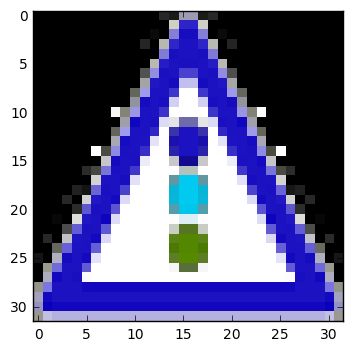

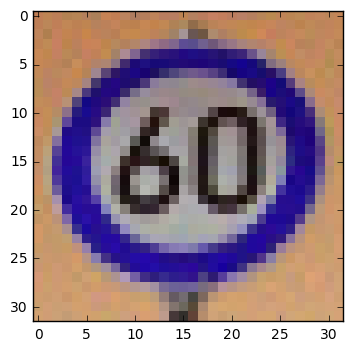

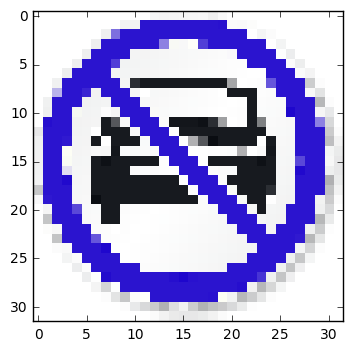

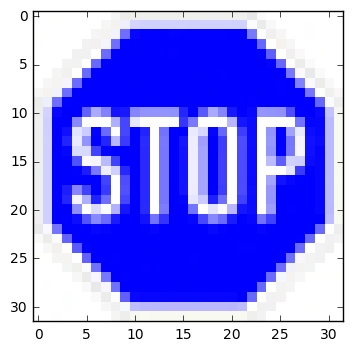

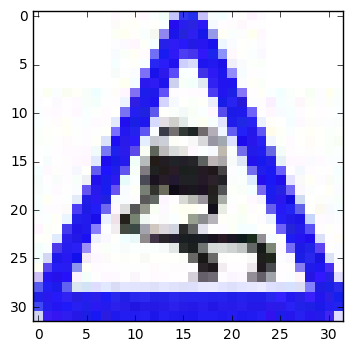

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# import os
# import cv2
#
# new_files = []
# for i in os.listdir('traffic_signs'):
#     if i.endswith('.p'):
#         continue
#     print(i)
#     img = cv2.imread('traffic_signs/{}'.format(i))
#     res = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
#     new_files.append(res)
#     del img
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
with open('traffic_signs/traf.p', 'rb') as f:
    new_files = pickle.load(f)

%matplotlib inline
for i in new_files:
    plt.imshow(i, interpolation='nearest', cmap=cm.brg)
    plt.show()

# temp = np.zeros_like(new_files, dtype=np.float32)
# temp = temp.reshape((-1, image_shape[0], image_shape[0], num_channels))
# for i, j in enumerate(new_files):
#     for k, l in enumerate(j):
#         temp[i][k] = np.mean(l)
# temp = temp[:i + 1, :, :]
# new_files = temp

# normalize the new image data
new_files = ((new_files - np.min(new_files)) / (np.max(new_files) - np.min(new_files)))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** The resizing process has altered the colour of these files, which creates a new challenge in identification, similar to the issue previously in training greyscale images. There is also as issue with images having different scaling as well as tinted angels which is not observable in the training dataset.

In [12]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('ts.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    sess.run(tf.global_variables_initializer())
    num_examples = len(new_files)
    softmax_predictions = sess.run(tf.nn.softmax(logits), feed_dict={tf_train_dataset: new_files,
                                                                     tf_train_labels: [26, 3, 15, 14, 23]})
    predictions = [[(i, k) for i, k in enumerate(softmax_predictions[j]) if k >= 1e-2]
                   for j in range(len(softmax_predictions))]
    accuracy = sess.run(accuracy_operation, feed_dict={tf_train_dataset: new_files,
                                                                     tf_train_labels: [26, 3, 15, 14, 23]})
    print("Real Image Test Accuracy = {:.3f}".format(accuracy))

Real Image Test Accuracy = 0.000


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**  There seems to be a great deal of uncertainty in dealing with this model and none of the 5 images has been correctly predicted. The model doesn occasionally predict one of them correctly however

In [14]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import operator
print('(Label, probability) for all predictions above 1%')
for i, j in zip(predictions, [26, 3, 15, 14, 23]):
    i = sorted(i, reverse=True, key=operator.itemgetter(1))[:5]
    print('Is correct label {} in top 5?'.format(j), j in [ii[0] for ii in i], '-', i)

(Label, probability) for all predictions above 1%
Is correct label 26 in top 5? False - [(13, 0.032713488), (16, 0.029677596), (35, 0.029444022), (6, 0.029097976), (32, 0.028856797)]
Is correct label 3 in top 5? False - [(13, 0.028649492), (32, 0.028061558), (6, 0.026907796), (14, 0.026814189), (16, 0.026725054)]
Is correct label 15 in top 5? False - [(13, 0.030343767), (32, 0.030310277), (41, 0.029791918), (24, 0.029414156), (35, 0.028890245)]
Is correct label 14 in top 5? False - [(13, 0.032714479), (32, 0.032351285), (16, 0.030457601), (24, 0.028861729), (35, 0.028651681)]
Is correct label 23 in top 5? False - [(13, 0.033910442), (41, 0.0311008), (32, 0.03054527), (16, 0.030138887), (6, 0.029999115)]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** As can be seen in the above extract, the probabilities are quite low for each image, and it seems the model is very uncertain in distinguishing between certain features. None of the correct labels were in the top 5 predicted labels. The model appears to be lacking distinct features that can dissociate each image.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.